In [7]:
import utils
from tqdm.notebook import tqdm
import sample as sampler
import numpy as np
dimension = 512
alpha = 16  # alpha error correcting parameter

## Utils

In [11]:
import numpy as np
def subset_n_a_k(n, a, k):
    result = 0
    for i in range(k):
        result += np.log2(n-i) - np.log2(n-a-i)
    return result

In [12]:
def generate_puzzle_local_search(new_bs, new_isometric_matrixes, k=160):
    """
    Behave as linear equation sampler that output "correct" matrix.

    generate matrix with row vectors from new_isometric_matrixes that orthognal to orignal template;
    k indicates the number of row vectors to be selected from each isometric matrix, thus the total number of equations is k*len(new_isometric_matrixes)
    """
    sub_matrixes = []
    for b, isometric_matrix in zip(new_bs, new_isometric_matrixes):
        indexb = np.where(np.abs(b) < 0.1)[0]
        # get random subset of shape n of indexb
        indexbb = np.random.choice(indexb, k, replace=False)
        sub_matrixes.append(isometric_matrix[indexbb, :])

    return np.concatenate(sub_matrixes, axis=0)

def generate_puzzle_local_search_random(new_bs, new_isometric_matrixes, k = 160):
    """
    Behave as linear equation sampler.

    generate matrix with row vector from new_isometric_matrixes randomly,
    k indicates the number of row vectors to be selected from each isometric matrix, thus the total number of equations is k*len(new_isometric_matrixes)
    """
    sub_matrixes = []
    for b, isometric_matrix in zip(new_bs, new_isometric_matrixes):
        # get random subset of shape n of indexb
        indexbb = np.random.choice(b.shape[0], k, replace=False)
        sub_matrixes.append(isometric_matrix[indexbb, :])

    return np.concatenate(sub_matrixes, axis=0)

In [13]:
import time
def local_search_each_runtime(dimension, alpha, sub_matrix, disable_flag=False, each_runtime=1000):
    """
    Test local search run time of inner iteration. Return time = time of inner iteration * each_runtime(number of outer iteration).
    """
    times = 0
    # time start
    start = time.time()
    for _ in (pbar:=tqdm(range(each_runtime), disable=disable_flag, leave=True)):
        theta = sampler.sample_codeword(dimension, alpha)
        flag = False
        # Since the inner iteration could early terminate, thus `800` is unreachable
        for _ in range(800):
            tmpb = sub_matrix @ theta
            # get the norm of tmpb
            normb = np.linalg.norm(tmpb)
            # get the index of tmpb where are not zero and iterate on it
            nonzero = np.where(np.abs(theta) > 0.1)[0]
            thetab = None
            tmp_sub_matrix = sub_matrix.copy()
            # set columns in non_zero positions with 10 * np.ones
            tmp_sub_matrix[:, nonzero] = 10 * np.ones((sub_matrix.shape[0], len(nonzero)))
            for j1 in nonzero:
                tmpbb = tmpb - theta[j1] * sub_matrix[:, j1]
                # add
                tmpbbb = tmp_sub_matrix + tmpbb[:, np.newaxis]
                normbbb = np.linalg.norm(tmpbbb, axis=0)
                # get min value and index of normbbb
                min_index = np.argmin(normbbb)
                min_value = normbbb[min_index]
                if min_value < normb:
                    thetab = theta.copy()
                    thetab[j1] = 0
                    thetab[min_index] = 1
                    normb = min_value
                # sub
                tmpbbb =  tmpbb[:, np.newaxis] - tmp_sub_matrix
                normbbb = np.linalg.norm(tmpbbb, axis=0)
                # get min value and index of normbbb
                min_index = np.argmin(normbbb)
                min_value = normbbb[min_index]
                if min_value < normb:
                    thetab = theta.copy()
                    thetab[j1] = 0
                    thetab[min_index] = -1
                    normb = min_value
            # pbar update
            pbar.set_postfix({"norm": normb})
            if thetab is not None:
                theta = thetab
                continue
            else:
                flag = True
                break
        if flag:
            times += 1
        pbar.set_postfix({"Reach ending times": times})
    end = time.time()
    slap_time = end - start
    return slap_time

## TEST

### Test for getting 3 sketches

average running time

In [ ]:
# time testing
whole_time = 0
tmp_inner = 100
tmp_outer = 10
tmpk = 150
error_rate = 0.29
for _ in (pbar:= tqdm(range(tmp_outer), desc="Outer loop")):
    # need to control n to indicate the number of sketches(default = 3)
    w, cs, isometric_matrixes, coserrors = sampler.generate_puzzle_n(dimension, alpha, error_rate=error_rate, n=3, disable_tqdm=True)
    # generate matrix M'
    new_isometric_matrixes = [isometric_matrixes[i] @ isometric_matrixes[0].T for i in range(1, len(isometric_matrixes))]
    new_cs = [cs[i] for i in range(1, len(cs))]
    # need to control k (set tmpk) to indicate the number of row vectors to be selected from each isometric matrix
    whole_time += local_search_each_runtime(dimension, alpha, generate_puzzle_local_search_random(new_cs, new_isometric_matrixes, k=tmpk), disable_flag=True, each_runtime=tmp_inner)
    pbar.set_postfix({"Whole Time": whole_time})
print("Average time for each inner iteration:", whole_time / (tmp_outer * tmp_inner))
print("Whole: Time", whole_time)

average success rate

given error rate and numbe of sampled linear equations in each matrix, experiment and get the rate of successfully solving a close enough solution to original template.

In [ ]:
import ironmask
import attacker
# error parameter and angle degree relation
# for more information, see example.ipynb
# 0.035 -> 2.8 degrees; 0.07-> 5.6 degrees; 0.108 -> 8.6 degrees; 0.13 -> 11 degrees;  
# 0.18 -> 14 degrees; 0.25 -> 19 degrees; 0.35 -> 26 degrees; 0.4 -> 30 degrees; 0.5 -> 36 degrees; 
error_rate_iter_arrays = [
    # [0.0, [60, 70, 80, 90]],
    # [0.0, [100, 110, 120, 130, 140, 160, 180, 200]],
    # [0.108, [120, 130, 140, 150, 160]],
    # [0.18, [130, 140, 150, 160]],
    # [0.25, [130, 140, 150, 160]],
    # [0.35, [160, 170, 180, 190]],
    # [0.4, [170]],
    # [0.4, [160, 170, 180, 190]],
    # [0.5, [180]],
    # [0.5, [180, 190, 200, 220, 240]],
    # [0.6, [200, 210]],
    # [0.6, [200, 220, 240, 260, 280, 300]],
    [0.75, [310, 320, 330, 340]],       
    # [0.75, [220, 240, 260, 280, 300, 350, 400]],
    # [0.92, [220]]         
]

k = 3   # number of sketches
iteration_number = 40000    # test times
angle_vec = []
for error_rate_iter_array in error_rate_iter_arrays:
    error_rate = error_rate_iter_array[0]
    iter_array = error_rate_iter_array[1]
    iter_array.reverse()
    for tmpk in iter_array:        
        success_num = 0
        fake_num = 0
        wrong_num = 0
        run_time = 0
        angle = 90
        angle_min = 90
        # for efficiency, we generate n = 4 * dimension + 1 sketches from the same original template with noise, and 
        # test at each time randomly selecting three sketches from this n sketches. 
        # take this three sketches as our puzzle
        w, cs, isometric_matrixes, coserrors = sampler.generate_puzzle_n(dimension, alpha, error_rate=error_rate, n= 4 * dimension + 1, disable_tqdm=False)
        for i in (pbar:=tqdm(range(iteration_number // 100))):
            # random select three templates from isometric_matrixes and get new_cs and new_isometric_matrixes
            index = np.random.choice(len(cs), k, replace=False)
            new_cs = [cs[index[i]] for i in range(k)]
            new_isometric_matrixes = [isometric_matrixes[index[i]] for i in range(k)]
            _, theta, tmp_run_times  = attacker.solve_puzzle_with_n_matrix_known_places(new_isometric_matrixes, new_cs, dimension, alpha, max_rtimes=100, disable_flag=True, threshold=53, algorithm="LSA", disable_tqdm=True, k_each_matrix=tmpk, error_rate=1.0, return_runtimes = True)
            if theta is not None:
                guess_cs_1 = new_isometric_matrixes[1] @ new_isometric_matrixes[0].T @ theta
                guess_cs_1 = ironmask.decode_codeword(guess_cs_1, dimension, alpha)
                angle = min(utils.get_angle_of_two_vectors(new_cs[1], guess_cs_1), utils.get_angle_of_two_vectors(-new_cs[1], guess_cs_1))
                angle_vec.append(angle)
                if np.allclose(theta, new_cs[0]) or np.allclose(-theta, new_cs[0]):
                    success_num += 1
                elif angle <= 0.01:
                    fake_num += 1
                else:
                    wrong_num += 1
                    angle_min = min(angle, angle_min)
            run_time += tmp_run_times
            pbar.set_postfix({"Success Rate": success_num/(i+1), "Success Number": success_num, "Fake Number": fake_num , "Angle": angle, "Min Angle": angle_min, "Run Time": run_time})
            # break if getting enough success times(for efficiency)
            if success_num > 100 and i > 1000:
                break
        # store threshold_array in file with name "threshold_array_k" in directory "data"
        np.save(f"data_with_noise_{k}/threshold_array_{tmpk}_{error_rate}_success_num_run_time", [success_num, run_time, fake_num, wrong_num])

### Estimate
how many iteration times need to output original template. (need to manually calculate) multiply inner iteration time of local search algorithm is the estimated time for running whole algorithm 

In [15]:
import numpy as np
import os
import math

# 0.035 -> 2.8 degrees; 0.07-> 5.6 degrees; 0.108 -> 8.6 degrees; 0.13 -> 11 degrees;  
# 0.18 -> 14 degrees; 0.25 -> 19 degrees; 0.35 -> 26 degrees; 0.4 -> 30 degrees; 0.5 -> 36 degrees; 
error_rate = 0.18
for i in [90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 280, 290, 300, 310, 320, 330, 340, 350, 400]:
    threshold_array = []
    if os.path.exists("data_with_noise_3/threshold_array_{}_{}_success_num_run_time.npy".format(i, error_rate)):
        results = np.load("data_with_noise_3/threshold_array_{}_{}_success_num_run_time.npy".format(i, error_rate))
        success_num = results[0]
        run_time = results[1]
        fake_num = 0 if len(results) <= 2 else results[2]
        whole_run_num = run_time
        if success_num == 0: 
            inverse_off_success_rate = 0
            expected_run_times = 0
        else:
            inverse_off_success_rate = whole_run_num / success_num
            expected_run_times = math.ceil(whole_run_num / success_num * 2 ** (subset_n_a_k(512, 16, i) * 2))
        print("{}".format(i), "success rate:{:.6f}".format(success_num / whole_run_num), " success number:", success_num, " fake number", fake_num, " inverse of success rate: ", inverse_off_success_rate, " Expected iteration number: ", "{:.6e}".format(expected_run_times))
        continue

130 success rate:0.001000  success number: 20  fake number 0  inverse of success rate:  1000.0  Expected iteration number:  1.385390e+07
140 success rate:0.002550  success number: 51  fake number 0  inverse of success rate:  392.15686274509807  Expected iteration number:  1.291896e+07
150 success rate:0.005120  success number: 101  fake number 0  inverse of success rate:  195.30693069306932  Expected iteration number:  1.567294e+07
160 success rate:0.007891  success number: 101  fake number 0  inverse of success rate:  126.72277227722772  Expected iteration number:  2.541096e+07


###  Test for getting (tmpk + 1) sketches

run time

In [ ]:
from tqdm import tqdm
whole_time = 0
tmp_inner = 100
tmp_outer = 10
tmpk = 340 * 2
error_rate = 0.6
for _ in (pbar:= tqdm(range(tmp_outer), desc="Outer loop")):
    w, cs, isometric_matrixes, coserrors = sampler.generate_puzzle_n(dimension, alpha, error_rate=error_rate, n=tmpk + 1, disable_tqdm=True)
    new_isometric_matrixes = [isometric_matrixes[i] @ isometric_matrixes[0].T for i in range(1, len(isometric_matrixes))]
    new_cs = [cs[i] for i in range(1, len(cs))]
    puzzle = generate_puzzle_local_search_random(new_cs, new_isometric_matrixes, k=1)
    whole_time += local_search_each_runtime(dimension, alpha, puzzle, disable_flag=True, each_runtime=tmp_inner)
    pbar.set_postfix({"Whole Time": whole_time})
print("Average inner running time: ", whole_time / (tmp_outer * tmp_inner))
print("Whole Time: ", whole_time)

average success rate

In [ ]:
import attacker
import ironmask
# 0.035 -> 2.8 degrees; 0.07-> 5.6 degrees; 0.108 -> 8.6 degrees; 0.13 -> 11 degrees;  
# 0.18 -> 14 degrees; 0.25 -> 19 degrees; 0.35 -> 26 degrees; 0.4 -> 30 degrees; 0.5 -> 36 degrees; 
error_rate_iter_arrays = [
    # [0.0, [130, 140, 150, 160, 170, 180]],
    # [0.108, [150, 160, 170]],
    # [0.18, [150, 160, 170]],
    # [0.25, [150, 160, 170]],
    # [0.35, [180, 190, 200, 210, 220]],
    # [0.4, [180, 190, 200, 210, 220]],
    # [0.5, [250, 260, 270, 280, 290, 300]],
    # [0.6, [320, 330, 340]],
    # [0.75, [620, 650, 670]],
    [0.92, [800, 900, 1000]]
]
iteration_number = 20000
for error_rate_iter_array in error_rate_iter_arrays:
    error_rate = error_rate_iter_array[0]
    iter_array = error_rate_iter_array[1]        # true tmpk = 2 * iter_array
    iter_array.reverse()
    for tmpk in iter_array:        
        tmpk *= 2
        success_num = 0
        fake_num = 0
        wrong_num = 0
        angle_min = 180
        angle = 180
        run_time = 0
        t_thrshold = 0
        # for efficiency, we generate 4 * dimension + 1 sketches from the same original template with noise, take first sketch and
        # test at each time randomly selecting tmpk sketches from these sketches, using these sketches as our puzzle
        w, cs, isometric_matrixes, coserrors = sampler.generate_puzzle_n(dimension, alpha, error_rate=error_rate, n = 6 * dimension + 1, disable_tqdm=False)
        for i in (pbar:=tqdm(range(iteration_number // 100))):
            index = np.random.choice(len(cs), tmpk, replace=False)
            new_isometric_matrixes = [isometric_matrixes[i] for i in index]
            new_cs = [cs[i] for i in index]
            _, theta, tmp_run_times = attacker.solve_puzzle_with_n_matrix_known_places(new_isometric_matrixes, new_cs, dimension, alpha, max_rtimes=100, disable_flag=True, threshold=60, algorithm="LSA", disable_tqdm=True, k_each_matrix=1, error_rate=1.0, return_runtimes=True)
            if theta is not None:
                guess_cs_1 = new_isometric_matrixes[1] @ new_isometric_matrixes[0].T @ theta
                guess_cs_1 = ironmask.decode_codeword(guess_cs_1, dimension, alpha)
                angle = min(utils.get_angle_of_two_vectors(new_cs[1], guess_cs_1), utils.get_angle_of_two_vectors(-new_cs[1], guess_cs_1))
                # angle_vec.append(angle)
                if np.allclose(theta, new_cs[0]) or np.allclose(-theta, new_cs[0]):
                    success_num += 1
                elif angle <= 0.01:
                    fake_num += 1
                else:
                    wrong_num += 1
                    angle_min = min(angle, angle_min)
            pbar.set_postfix({"Success Rate": success_num/(i+1), "Success Number": success_num, "Fake Number": fake_num , "Angle": angle, "Min Angle": angle_min, "Run Time": run_time})
            # break if getting enough success times(for efficiency)
            run_time += tmp_run_times
            if success_num > 100 and i > 1000:
                break
        # store threshold_array in file with name "threshold_array_k" in directory "data"
        np.save(f"data_with_noise_k/threshold_array_{tmpk}_{error_rate}_success_num_run_time", [success_num, run_time, fake_num, wrong_num])

### Estimate
how many iteration times need to output original template, multiply inner iteration time of local search algorithm is the estimated time for running whole algorithm 

In [ ]:
import numpy as np
import os
import math

# 0.035 -> 2.8 degrees; 0.07-> 5.6 degrees; 0.108 -> 8.6 degrees; 0.13 -> 11 degrees;  
# 0.18 -> 14 degrees; 0.25 -> 19 degrees; 0.35 -> 26 degrees; 0.4 -> 30 degrees; 0.5 -> 36 degrees; 

error_rate = 0.6
for i in [90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 500, 550, 600, 620, 650, 670, 700, 800]:
    i = i * 2
    if os.path.exists("data_with_noise_k/threshold_array_{}_{}_success_num_run_time.npy".format(i, error_rate)):
        results = np.load("data_with_noise_k/threshold_array_{}_{}_success_num_run_time.npy".format(i, error_rate))
        success_num = results[0]
        run_time = results[1]
        fake_num = 0 if len(results) <= 2 else results[2]
        whole_run_num = run_time
        if success_num == 0: 
            inverse_off_success_rate = 0
            expected_run_times = 0
        else:
            inverse_off_success_rate = whole_run_num / success_num
            expected_run_times = math.ceil(whole_run_num / success_num * 2 ** (subset_n_a_k(512, 16, 1) * i))
        print("{}".format(i), "success rate:{:.6f}".format(success_num / whole_run_num), " success number:", success_num, " fake number", fake_num, " inverse of success rate: ", inverse_off_success_rate, " Expected iteration number: ", "{:.6e}".format(expected_run_times))

local minimum of t_all

260 success rate:0.000600  success number: 12  fake number 0  inverse of success rate:  1666.6666666666667  Expected iteration number:  6.409184e+06
280 success rate:0.001350  success number: 27  fake number 0  inverse of success rate:  740.7407407407408  Expected iteration number:  5.375092e+06
300 success rate:0.002200  success number: 44  fake number 0  inverse of success rate:  454.54545454545456  Expected iteration number:  6.223901e+06
320 success rate:0.002900  success number: 58  fake number 0  inverse of success rate:  344.82758620689657  Expected iteration number:  8.909494e+06


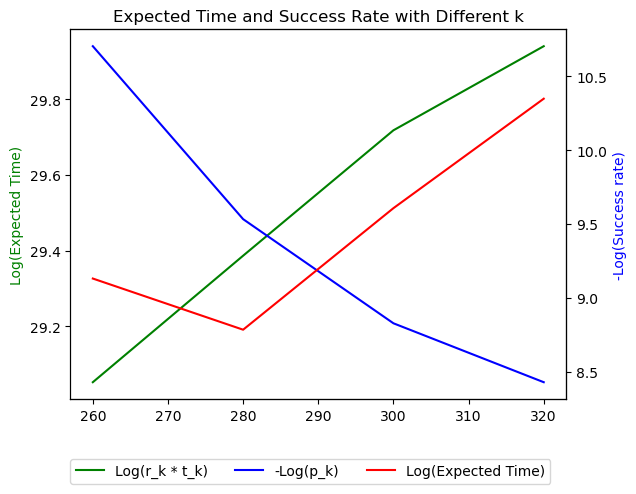

In [ ]:
import numpy as np
import os
import math

# 0.035 -> 2.8 degrees; 0.07-> 5.6 degrees; 0.108 -> 8.6 degrees; 0.13 -> 11 degrees;  
# 0.18 -> 14 degrees; 0.25 -> 19 degrees; 0.35 -> 26 degrees; 0.4 -> 30 degrees; 0.5 -> 36 degrees; 
error_rate = 0.0
k_vec = []
log2_expected_run_times_vec = []
success_prob_vec = []
expected_each_time = [105, 114, 123, 105]
# expected_each_time = [100] * 4
for i, each_time in zip([130, 140, 150, 160], expected_each_time):
    i = i * 2
    threshold_array = []
    if os.path.exists("data_with_noise_k/threshold_array_{}_{}_success_num_run_time.npy".format(i, error_rate)):
        results = np.load("data_with_noise_k/threshold_array_{}_{}_success_num_run_time.npy".format(i, error_rate))
        success_num = results[0]
        run_time = results[1]
        fake_num = 0 if len(results) <= 2 else results[2]
        whole_run_num = run_time
        if success_num == 0: 
            inverse_off_success_rate = 0
            expected_run_times = 0
            continue
        else:
            inverse_off_success_rate = whole_run_num / success_num
            expected_run_times = math.ceil(whole_run_num / success_num * 2 ** (subset_n_a_k(512, 16, 1) * i))
        k_vec.append(i)
        log2_expected_run_times_vec.append(subset_n_a_k(512, 16, 1) * i + np.log2(each_time))
        success_prob_vec.append(success_num / whole_run_num)
        print("{}".format(i), "success rate:{:.6f}".format(success_num / whole_run_num), " success number:", success_num, " fake number", fake_num, " inverse of success rate: ", inverse_off_success_rate, " Expected iteration number: ", "{:.6e}".format(expected_run_times))
        continue

import matplotlib.pyplot as plt
log2_success_prob_vec = -np.log2(np.array(success_prob_vec, dtype=np.float64))
sum_vec = log2_expected_run_times_vec + log2_success_prob_vec


fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax3 = ax1.twinx() 

# ax1.spines['left'].set_position(('outward', 60))
ax1.spines['left'].set_color('none')
ax1.yaxis.set_ticks([]) 
ax1.yaxis.set_ticklabels([])  


# ax3.spines['left'].set_position(('outward', 60))
ax3.spines['left'].set_color('black') 
ax3.yaxis.set_ticks_position('left')  
ax3.yaxis.set_label_position('left') 

y_min, y_max = min(sum_vec), max(sum_vec)
y_range = y_max - y_min
ax3.set_ylim(y_min - 0.3 * y_range, y_max + 0.3 * y_range)

line1, = ax1.plot(k_vec, log2_expected_run_times_vec, 'g-', label='Log(r_k * t_k)')
line2, = ax2.plot(k_vec, log2_success_prob_vec, 'b-', label='-Log(p_k)')
line3, = ax3.plot(k_vec, sum_vec, 'r-', label='Log(Expected Time)')
lines = [line1, line2, line3]
labels = [line.get_label() for line in lines]
fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 0), ncol=3)

ax3.set_xlabel('k')
ax3.set_ylabel('Log(Expected Time)', color='g')
ax2.set_ylabel('-Log(Success rate)', color='b')

plt.title('Expected Time and Success Rate with Different k')

plt.savefig('Expected_Time_Success_Rate.pdf', format='pdf', dpi=300, bbox_inches='tight')

plt.show()
